# Clustering Pitcher Types to Better Predict Batter Outcomes

<br>
The objective of this project is to predict batter performance more accurately. Currently, the most common way of predicting a batter’s performance is by using his previous performance as a predictor for his future performance. In other words, we are asking the question: Given a batter’s previous batting average (or other performance metric), what is the expected result of his next at bat? When coaches or baseball fans try to obtain a more accurate prediction for what will happen during the next at bat, they sometimes adjust the batter’s past performance based on how he fared against left-handed pitchers (LHP) and right-handed pitchers (RHP). Even more specifically, people may use a batter's past performance against that specific pitcher to predict his future performance. For example, a batter who has gone 1 for 8 against a pitcher might be predicted to have a .125 battering average against that pitcher in the future. Unfortunately, each of these techniques to predict batter performance are ineffective. Using pitcher-specific batting averages almost always leads to sample sizes too small to be significant. Overall batting averages might be accurate over the course of a season, but surely there is information about the batter/pitcher matchup to help generate a more specific prediction than using a season long average. What if we grouped similar pitchers together, such that batters are likely to perform similarly against any pitcher within each group? If we are able to accurately divide pitchers into *types*, then each hitter could have an adjusted batting average against each *type* of pitcher, which would have a big enough sample size to be statistically significant but also be much more specific than just looking at overall batting averages.


## Notebook Structure
1. Notebook Prerequisites<br>
    1.1 Web Scrape Pitch Data from BrooksBaseball<br>
    1.2 Download At Bat Data from Pitch F/X<br>
2. Data Manipulation<br>
    2.1 Combine Similar Pitches<br>
    2.2 Take a weighted average of Pitch Types<br>
    2.3 Data Filtering<br>
    2.4 Calculate Pitch Frequencies and Velo Index<br>
    2.5 Data Normalization<br>
3. Feature Analysis<br>
    3.1 Correlation<br>
    3.2 Variance<br>
4. Cluster Analysis<br>
    4.1 Finding k through the Elbow Method<br>
    4.2 Hierarchical Clustering - Plotting the Dendrogram<br>
    4.3 Analyzing Cluster Centers<br>
    4.4 Add Clusters to *atbat* Table<br>
5. Model Analysis<br>
    5.1 Divide atbats into Training and Testing Data<br>
    5.2 Calculate wOBP<br>
    5.3 Filter out Infrequent Batters<br>
    5.4 Use Training Stats as Predictions<br>

## 1. Notebook Prequisites

As a prerequisite to running this notebook, I downloaded data from Pitch F/X and scraped pitching data from BrooksBaseball. Pitch F/X provides a comprehensive dataset for all pitches and at bats going back to 2008. Pitches in the Pitch F/X database are classified into pitch types using a neural network, which feeds into real-time applications such as MLB Gameday. While Pitch F/X's pitch classifier was revolutionary when it was first created, and does a good job in general, it is not entirely accurate. Attempts to base further analysis on these pitch types suffer because of this lack of accuracy. BrooksBaseball has tried to improve upon Pitch F/X's classification by manually adjusting pitch types based on pitchers grips of the baseball, catchers signs, and discussions with coaches and the pitchers themselves. This improved accuracy opens the door for further analysis based on the pitch type classifications.
Unfortunately, BrooksBaseball does not have an API to download their data. In order to use their improved pitch type classifications I created a web-scraping tool to extract the updated pitch type for every pitch thrown in the past 5 years. I stored this pitching data in a sqlite table called pitches. For convenience, I've merged the Pitch F/X data into a table called atbats within the same database as the pitches table. Note that the R script (using the R package mlbgameday) to download Pitch F/X data and the python script to scrape BrooksBaseball are stored in this github repository.

First, I import the required python modules and settings.

In [1]:
# external imports 
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
from kneed import KneeLocator
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
import itertools
import copy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import sqlite3
from IPython.core.interactiveshell import InteractiveShell

# Custom scripts
import src.constants as constants

# Notebook Settings
InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.chained_assignment = None

Next, I connect to the sqlite database that contains the *pitches* table and *atbats* table.

In [2]:
conn = sqlite3.connect(constants.COMBINED_DB_NAME)

### 1.1 Web Scrape Pitch Data from BrooksBaseball

Here is a view of my *pitches* table. I will use this data to cluster pitchers into types based on the frequency that they throw each pitch, as well as their velocities.

In [3]:
def load_pitches_table():
    sql = "select * from pitches;"
    return pd.read_sql_query(sql, conn)

pitches = load_pitches_table()
pitches.head()

,pitcher_id,game_id,b_stands,pitch_type_code,pitch_type_desc,velo,count
0,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,FA,Fastball,89.0,17.0
1,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,SI,Sinker,88.8,3.0
2,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,CH,Changeup,83.5,2.0
3,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,CU,Curveball,75.6,14.0
4,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,FC,Cutter,86.1,17.0


### 1.2 Download At Bat Data from Pitch F/X

Here is a view of my *atbats* table. I will eventually use this data to determine how batters perform against each pitcher type.

In [4]:
def load_atbats_table():
    sql = "select * from atbats;"
    return pd.read_sql_query(sql, conn)

atbats = load_atbats_table()
atbats.tail()

,pitcher_id,batter_id,p_throws,b_stands,batter_name,pitcher_name,event,game_id
953826,450203.0,523253.0,R,R,Logan Forsythe,Charlie Morton,Flyout,gid_2017_11_01_houmlb_lanmlb_1
953827,450203.0,605131.0,R,R,Austin Barnes,Charlie Morton,Lineout,gid_2017_11_01_houmlb_lanmlb_1
953828,450203.0,400284.0,R,L,Chase Utley,Charlie Morton,Strikeout,gid_2017_11_01_houmlb_lanmlb_1
953829,450203.0,621035.0,R,R,Christopher Taylor,Charlie Morton,Groundout,gid_2017_11_01_houmlb_lanmlb_1
953830,450203.0,608369.0,R,L,Corey Seager,Charlie Morton,Groundout,gid_2017_11_01_houmlb_lanmlb_1


## 2. Data Manipulation

### 2.1 Combine Similar Pitches

Here is a breakdown of the frequency of different pitch types in the *pitches* table.

In [5]:
def show_pitch_type_counts(df):
    sql = """select pitch_type_code, pitch_type_desc, count(*) as count
             from {} 
             group by pitch_type_code, pitch_type_desc
             order by count desc""".format(df)
    return pd.read_sql_query(sql, conn)

show_pitch_type_counts("pitches")

,pitch_type_code,pitch_type_desc,count
0,FA,Fastball,121740
1,SL,Slider,83121
2,SI,Sinker,67579
3,CU,Curveball,59776
4,CH,Changeup,56935
5,FC,Cutter,29103
6,FS,Splitter,9794
7,FF,Four-seam Fastball,4317
8,FT,Two-seam Fastball,1822
9,CS,Slow Curve,516


Some pitch types are essentially different names for the same pitch and should therefore be grouped together. For example, a sinker **is** a two-seam fastball. Some pitchers simply call their two-seam fastball a sinker because it has downward movement, but essentially it is still a two-seam fastball. Therefore, it makes sense to group these two pitches together. Similarly, I am grouping fastballs and four-seam fastball together, since I believe these are variations of the same pitch in the dataset. This same logic applies for curveballs, slow curves, and knuckle-curves. 

Here is the breakdown of pitch frequencies after grouping similar pitches together.

In [6]:
def group_similar_pitches_together(pitches):   
    df = pitches.copy(deep=True) 
    df.loc[(df.pitch_type_code=='SI'), 
           ['pitch_type_code', 'pitch_type_desc']] = ['FT', 'Two-seam Fastball']
    
    df.loc[(df.pitch_type_code=='FA'),
           ['pitch_type_code', 'pitch_type_desc']] = ['FF', 'Four-seam Fastball']
    
    df.loc[(df.pitch_type_code=='CS') | (df.pitch_type_code=='KC'),
           ['pitch_type_code', 'pitch_type_desc']] = ['CU', 'Curveball']
    return df
    
adjusted_pitches = group_similar_pitches_together(pitches)
adjusted_pitches.to_sql("adjusted_pitches", conn, if_exists="replace")
show_pitch_type_counts("adjusted_pitches")

,pitch_type_code,pitch_type_desc,count
0,FF,Four-seam Fastball,126057
1,SL,Slider,83121
2,FT,Two-seam Fastball,69401
3,CU,Curveball,60706
4,CH,Changeup,56935
5,FC,Cutter,29103
6,FS,Splitter,9794
7,KN,Knuckleball,339
8,FO,Forkball,10
9,SB,Screwball,9


The knuckleball, forkball, and screwball are thrown so infrequently that they shouldn't get their own categories as fields and can be grouped into an *Other* category. 

In [7]:
def group_rare_pitches_into_other_category(df):
    df.loc[(df.pitch_type_code=='KN') 
         | (df.pitch_type_code=='FO')
         | (df.pitch_type_code=='SB'),
           ['pitch_type_code', 'pitch_type_desc']] = ['NA', 'Other']
    
group_rare_pitches_into_other_category(adjusted_pitches)
adjusted_pitches.to_sql("adjusted_pitches", conn, if_exists="replace")
show_pitch_type_counts("adjusted_pitches")

,pitch_type_code,pitch_type_desc,count
0,FF,Four-seam Fastball,126057
1,SL,Slider,83121
2,FT,Two-seam Fastball,69401
3,CU,Curveball,60706
4,CH,Changeup,56935
5,FC,Cutter,29103
6,FS,Splitter,9794
7,NA,Other,358


### 2.2 Take a weighted average of Pitch Types

Now that we've consolidated the pitches into their more general classifications, let's start working on the pitch statistics.

In [8]:
adjusted_pitches.head()

,pitcher_id,game_id,b_stands,pitch_type_code,pitch_type_desc,velo,count
0,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,FF,Four-seam Fastball,89.0,17.0
1,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,FT,Two-seam Fastball,88.8,3.0
2,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,CH,Changeup,83.5,2.0
3,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,CU,Curveball,75.6,14.0
4,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,FC,Cutter,86.1,17.0


Each row in the adjusted_pitches table contains a pitch_type_code and a *count* field. For example the first row is four-seam fastball with a count of 17. This indicates that pitcher_id 425794 had an appearance where he threw 17 fastballs, at an average velocity of 89.0 MPH. There will be many "FF" rows for that pitcher_id, one for each of his appearances where he threw at least 1 four-seam fastball. 

In [9]:
def show_pitcher_id_425794(df):
    pitcher_425794 = df.loc[(df["pitcher_id"] == 425794)
                          & (df["pitch_type_code"] == "FF")]
    
    interesting_fields = pitcher_425794[["pitcher_id","game_id","b_stands",
                                         "pitch_type_code", "pitch_type_desc","velo","count"]]
    
    return interesting_fields.head()

show_pitcher_id_425794(adjusted_pitches).reset_index(drop=True)

,pitcher_id,game_id,b_stands,pitch_type_code,pitch_type_desc,velo,count
0,425794,gid_2015_04_05_slnmlb_chnmlb_1/,L,FF,Four-seam Fastball,89.0,17.0
1,425794,gid_2015_04_05_slnmlb_chnmlb_1/,R,FF,Four-seam Fastball,89.3,18.0
2,425794,gid_2015_04_13_milmlb_slnmlb_1/,L,FF,Four-seam Fastball,89.4,3.0
3,425794,gid_2015_04_13_milmlb_slnmlb_1/,R,FF,Four-seam Fastball,90.9,12.0
4,425794,gid_2015_04_19_cinmlb_slnmlb_1/,L,FF,Four-seam Fastball,89.8,6.0


In order to get an accurate view of this pitcher's typical fastball, we need to take a weighted average of all of his fastballs across all appearances.

In [10]:
def generate_weighted_totals(adjusted_pitches):

    # Get the total number of pitches for each pitch type for every pitcher
    # Remove pitches with a velo under 65
    sql = """select pitcher_id, b_stands, pitch_type_code,
                sum(count) as pitch_type_total
                from adjusted_pitches 
                where velo > 65
                group by pitcher_id, b_stands, pitch_type_code;
            """
    pitch_type_totals = pd.read_sql_query(sql, conn)

    # Add pitch_type_total to each pitcher for each pitch type
    join_conditions = ['pitcher_id', 'b_stands', 'pitch_type_code']
    frequency_table = pd.merge(pitch_type_totals, adjusted_pitches, 
                               how='left', 
                               left_on=join_conditions,
                               right_on=join_conditions)
    frequency_table.to_sql("frequency_table", conn, if_exists="replace")

    # Weight each pitcher's stats by the number of pitches thrown from that appearance
    #    compared to total number of pitches thrown for that pitcher of that pitch type
    sql = """select pitcher_id, b_stands, 
                pitch_type_code, pitch_type_total,
                sum(velo*(1.0*count/pitch_type_total)) as velo
                from frequency_table 
                group by pitcher_id, b_stands, 
                pitch_type_code, pitch_type_total;
            """
    weighted_totals = pd.read_sql_query(sql, conn)
    weighted_totals.to_sql("weighted_totals", conn, if_exists="replace")

    # Drop the temporary table
    cursor = conn.cursor()
    cursor.execute("drop table frequency_table;")
    cursor.close()

    # Add the total number of pitches as a column in weighted_totals table
    sql = """select pitcher_id, b_stands,
                sum(pitch_type_total) as total_count
                from weighted_totals
                group by pitcher_id, b_stands;
            """
    total_count_table = pd.read_sql_query(sql, conn)
    join_conditions = ['pitcher_id', 'b_stands']
    weighted_totals = pd.merge(weighted_totals, total_count_table, 
                                   how='left',
                                   left_on=join_conditions,
                                   right_on=join_conditions)
    return weighted_totals
    
    
weighted_totals = generate_weighted_totals(adjusted_pitches)
weighted_totals.to_sql("weighted_totals", conn, if_exists="replace")
weighted_totals.head()

,pitcher_id,b_stands,pitch_type_code,pitch_type_total,velo,total_count
0,112526,L,CH,511.0,81.478669,4868.0
1,112526,L,FC,130.0,86.343846,4868.0
2,112526,L,FF,1455.0,90.331890,4868.0
3,112526,L,FT,2616.0,87.542049,4868.0
4,112526,L,SL,156.0,81.412821,4868.0


### 2.3 Data Filtering

There were a handful of pitches that showed suspicious velocities, even as low as 10 mph. These data points seem like data issues, and so to avoid using these velocities in the averages I filtered out any pitches with velocities below 65 mph. Next, I need to filter out pitchers who had thrown too few pitches to show any meaningful data. To do this I filtered out pitchers who had thrown fewer than 200 pitches.

In [11]:
def filter_out_uncommon_pitchers():
    cursor = conn.cursor()
    sql = "delete from weighted_totals where total_count < 200;"
    cursor.execute(sql)
    cursor.close()
    conn.commit();

filter_out_uncommon_pitchers()

### 2.4 Calculate Pitch Frequencies and Velo Index

Next, I calculated the percentage that each pitcher throws each kind of pitch by dividing the number of pitches thrown for each specific pitch type by the total number of pitches thrown. To try to quantify how fast a pitcher throws, I also created a field called *velo_index* by calculating each pitcher's average fastball velocity (or the average velocity of each pitcher's fastest pitch type).

In [12]:
def generate_pitch_frequencies_table():
    create_pitch_frequencies_table()
    cursor = conn.cursor()
    sql = "select distinct pitcher_id, b_stands from weighted_totals;"
    cursor.execute(sql)
    rows = cursor.fetchall()
    cursor.close()

    pitch_frequencies_rows = []
    for (pitcher_id, b_stands) in rows:
        row = [pitcher_id, b_stands]

        # Add a column for each of these pitch_type_codes
        for pitch_type_code in ["FF", "FT", "FC", "FS", "CH", "CU", "SL", "NA"]:
            percent_for_type = get_frequency(conn,
                                             pitcher_id,
                                             b_stands,
                                             pitch_type_code)
            row.append(percent_for_type)

        # Add velo index
        row.append(get_velo_index(conn, pitcher_id, b_stands))

        # Add row to list
        pitch_frequencies_rows.append(row)
        
        
    sql = """insert into pitch_frequencies (pitcher_id, b_stands,
                percent_ff, percent_ft, percent_fc, percent_fs, percent_ch,
                percent_cu, percent_sl, percent_na, velo_index)
                values (?,?,?,?,?,?,?,?,?,?,?)
            """
    cursor = conn.cursor()
    cursor.executemany(sql, pitch_frequencies_rows)
    conn.commit();
    
    return pd.read_sql_query("select * from pitch_frequencies;", conn);


def create_pitch_frequencies_table():
    cursor = conn.cursor()
    cursor.execute("drop table if exists pitch_frequencies;")
    cursor.close()
    
    sql = """ CREATE TABLE pitch_frequencies 
               (pitcher_id          INT     NOT NULL,
                b_stands            TEXT    NOT NULL,
                percent_ff          REAL    NOT NULL,
                percent_ft          REAL    NOT NULL,
                percent_fc          REAL    NOT NULL,
                percent_fs          REAL    NOT NULL,
                percent_ch          REAL    NOT NULL,
                percent_cu          REAL    NOT NULL,
                percent_sl          REAL    NOT NULL,
                percent_na          REAL    NOT NULL,
                velo_index          REAL    NOT NULL,
                PRIMARY KEY(pitcher_id, b_stands)
            ); """
    cursor = conn.cursor()
    cursor.execute(sql)
    cursor.close();
    
    
def get_frequency(conn, pitcher_id, b_stands, pitch_type_code):
    cursor = conn.cursor()
    sql = """select pitch_type_total/total_count 
                from weighted_totals
                where pitcher_id = ? 
                and b_stands = ? 
                and pitch_type_code = ?
            """
    cursor.execute(sql, [pitcher_id, b_stands, pitch_type_code])
    result = cursor.fetchone()
    
    if result is None:
        percent_thrown = 0
    else:
        percent_thrown = result[0]
    cursor.close()
    
    return percent_thrown


def get_velo_index(conn, pitcher_id, b_stands):
    cursor = conn.cursor()
    sql = """select max(velo_index) 
                from (select avg(velo) as velo_index 
                        from weighted_totals
                        where pitcher_id = ?
                        and b_stands = ?
                        group by pitch_type_code,
                        pitcher_id, b_stands
                     );
            """
    cursor.execute(sql, [pitcher_id, b_stands])
    velo_index = cursor.fetchone()[0]
    cursor.close()
    return velo_index


pitch_frequencies = generate_pitch_frequencies_table()
pitch_frequencies.head()

,pitcher_id,b_stands,percent_ff,percent_ft,percent_fc,percent_fs,percent_ch,percent_cu,percent_sl,percent_na,velo_index
0,112526,L,0.298891,0.537387,0.026705,0.0,0.104971,0.000000,0.032046,0.0,90.331890
1,112526,R,0.167743,0.661486,0.009084,0.0,0.049657,0.000202,0.111829,0.0,90.455836
2,115629,L,0.009772,0.674267,0.000000,0.0,0.104235,0.019544,0.192182,0.0,93.561836
3,115629,R,0.033835,0.785714,0.000000,0.0,0.033835,0.007519,0.139098,0.0,94.147847
4,150116,R,0.165485,0.321513,0.222222,0.0,0.125296,0.163121,0.002364,0.0,89.437143


### 2.5 Data Normalization

Next, I need to normalize my dataset so that I can effectively cluster pitchers without the units affecting the distance metrics. My features are made up of percentages of pitch types, as well as a velo index. The pitch type percentages are already scaled between 0 and 1, because they were calculated as the percentage of pitches that the pitcher throws for each pitch type. The velo index ranges from the low 80's to a little over 100, and is stored in MPH. In order to perform clustering I will need to scale this feature down to a range between 0 and 1 so it doesn't completely overpower the other features. However, simply scaling the velo index down to a range between 0 and 1 will not completely solve the problem. Here is a look at the density of values for each feature.

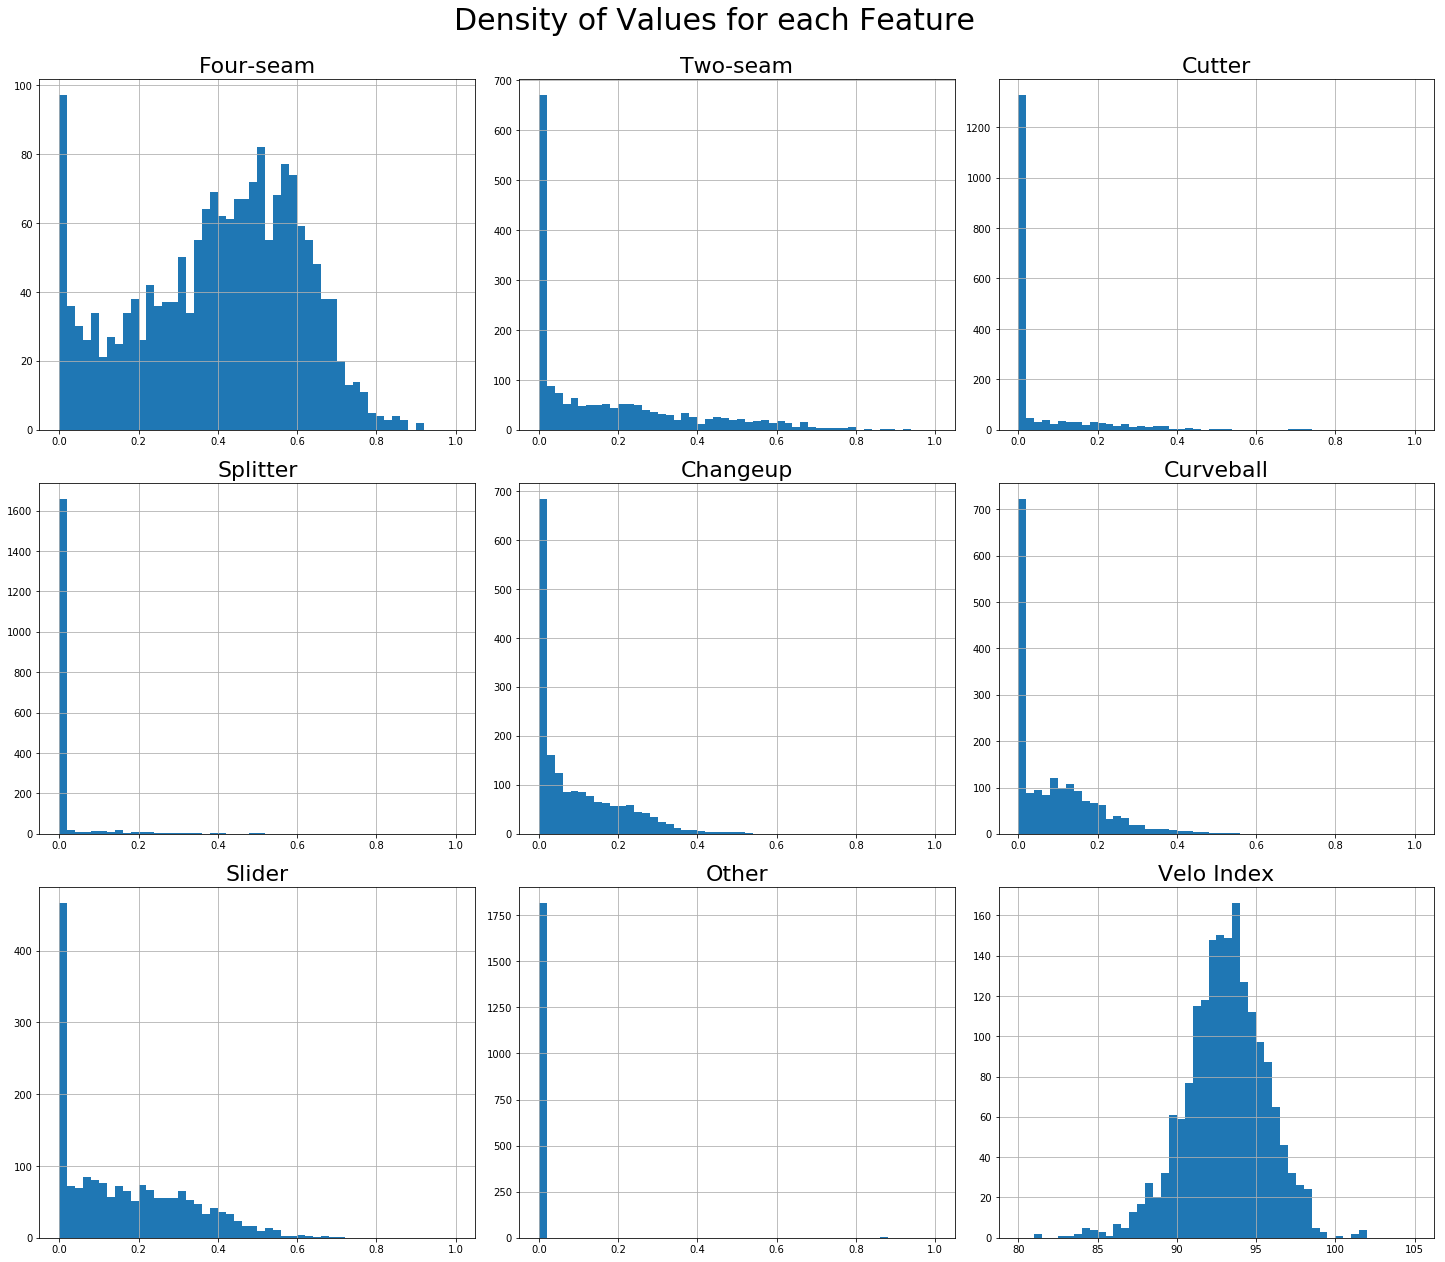

In [13]:
# Labels of features to be used in multiple charts
labels = ["Four-seam", "Two-seam", "Cutter",
          "Splitter", "Changeup", "Curveball",
          "Slider", "Other", "Velo Index"]

def plot_histograms_of_features(df):
    fields_to_drop = ["pitcher_id", "b_stands"]
    df = df.drop(fields_to_drop, axis=1)
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(25, 20))
    for i, ax in enumerate(axes.flat):
        hist_range = [80,105] if labels[i] == "Velo Index" else [0,1]
        df.hist(column=df.columns[i], range=hist_range, bins=50, ax=ax, align='mid')
        ax.set_title(labels[i], fontsize=22)
            
    fig.subplots_adjust(hspace=.15, wspace=.1)
    fig.subplots_adjust(top=0.93)
    fig.suptitle("Density of Values for each Feature", fontsize=30)
    plt.show();

plot_histograms_of_features(pitch_frequencies)

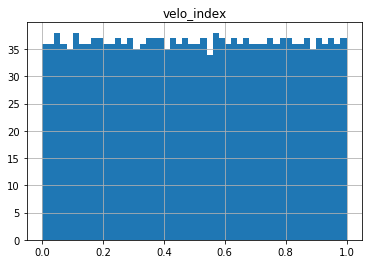

In [14]:
def normalize_velo_index(pitch_frequencies):
    df = pitch_frequencies.copy(deep=True)
    scaler = QuantileTransformer(output_distribution='uniform')
    x = df[['velo_index']].values.astype(float)
    df["velo_index"] = scaler.fit_transform(x)
    return df

normalized = normalize_velo_index(pitch_frequencies)
normalized.to_sql("normalized", conn, if_exists="replace")
normalized.hist(column='velo_index', align='mid', bins=50);

## 3. Feature Analysis

Now that the data is ready for analysis, I divide the dataset into RHP and LHP.

In [15]:
def get_normalized_splits():
    df_list = []
    for p_throws in ["R", "L"]:
        sql = """select n.*, a.p_throws
                 from normalized n
                 left join atbats a
                 on n.pitcher_id = a.pitcher_id
                 where a.p_throws='{}' 
                 group by n.pitcher_id;
                """.format(p_throws)   
        
        df = pd.read_sql_query(sql, conn).drop(["index"], axis=1)
        df_list.append(df)
        
    return df_list[0], df_list[1]

    
normalized_rhp, normalized_lhp = get_normalized_splits()
normalized_rhp.head()

,pitcher_id,b_stands,percent_ff,percent_ft,percent_fc,percent_fs,percent_ch,percent_cu,percent_sl,percent_na,velo_index,p_throws
0,112526,R,0.167743,0.661486,0.009084,0.000000,0.049657,0.000202,0.111829,0.0,0.140661,R
1,115629,R,0.033835,0.785714,0.000000,0.000000,0.033835,0.007519,0.139098,0.0,0.667180,R
2,150302,R,0.000000,0.571429,0.000000,0.105121,0.000000,0.000000,0.323450,0.0,0.047094,R
3,150359,R,0.133782,0.554559,0.000000,0.000000,0.029148,0.282511,0.000000,0.0,0.297355,R
4,218596,R,0.091603,0.423664,0.353053,0.020038,0.000000,0.111641,0.000000,0.0,0.052327,R


### 3.1 Correlation 

To visualize how variables are related to each other I plotted a correlation for RHP and LHP.

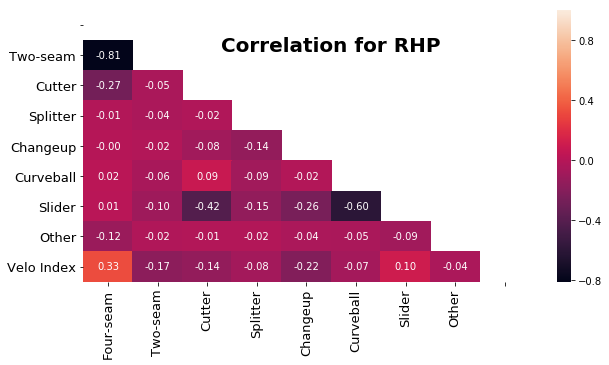

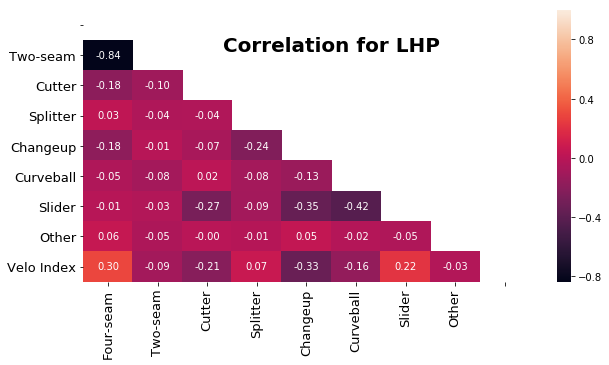

In [16]:
def plot_correlation_matrix_grid(df1, df2):
    p_throws_list = ["RHP", "LHP"]
    df_list = [df1, df2]
    for i in range(0, len(df_list)):       
        df = df_list[i]
        
        # Get data from data_section
        fields_to_drop = ["pitcher_id", "p_throws", "b_stands"]
        corr = df.drop(fields_to_drop, axis=1).corr()

        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

        # generate heatmap
        plt.figure(figsize=(10, 5))
        fig = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f")

        # Set labels and title
        fig.set_xticklabels(labels[:-1], rotation=90, fontsize=13)
        temp = copy.deepcopy(labels)
        temp[0] = ""
        fig.set_yticklabels(temp, fontsize=13)
        title = "Correlation for {}".format(p_throws_list[i])
        fig.text(x=5, y=1.5, s=title, fontsize=20,
                 weight='bold', ha='center', va='bottom')

        # Display heatmap
        plt.show();

plot_correlation_matrix_grid(normalized_rhp, normalized_lhp)

There are several themes across each of these correlation matrices. The strongest correlation (positive or negative) is a negative correlation between four-seamers (FF) and two-seamers (FT). This makes sense because these two pitches are often substitutes for each other. Along those same lines, cutters (FC) are negatively correlated with four-semears too. Another strong correlation is a negative relationship between sliders (SL) and curveballs (CU), which makes sense because pitchers usually throw one or the other but not both. Velo index is positively correlated with four-seamers and sliders, both pitches that many power pitchers throw.

### 3.2 Variance

Next, I calculated the variance for every variable for both RHP and LHP. Variables with very low variance can be problematic as they have little predictive power and can negatively affect the other more influential variables.

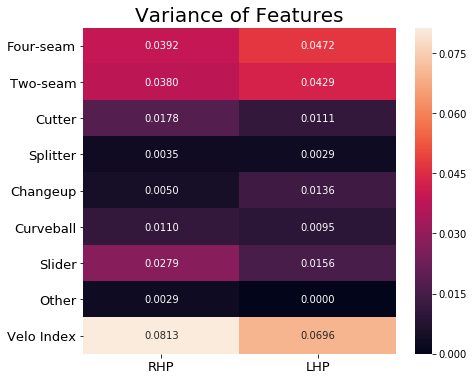

In [17]:
def analyze_variance_threshold(df1, df2):
    variance_list = []
    titles = []
    p_throws_list = ["RHP", "LHP"]
    df_list = [df1, df2]
    for i in range(0, len(df_list)):       
        df = df_list[i]
        fields_to_drop = ["pitcher_id", "p_throws", "b_stands"]
        df = df.drop(fields_to_drop, axis=1)
        variance_list.append(df.var())
        titles.append(p_throws_list[i])
        
    return pd.concat(variance_list, axis=1, keys=titles)


def plot_variance_heatmap(df):
    plt.figure(figsize=(7, 6))
    g = sns.heatmap(df, annot=True, fmt=".4f")
    loc, lab = plt.xticks()
    g.set_xticklabels(lab, fontsize=13)
    g.set_yticklabels(labels, fontsize=13)
    g.set_title("Variance of Features", fontsize=20)

variance = analyze_variance_threshold(normalized_rhp, normalized_lhp)
plot_variance_heatmap(variance)

We can learn a lot of valuable information from this heatmap. Velo index easily has the most variance, which makes sense because I've normalized the data to be evenly distributed across the range of 0 to 1. Therefore, small changes in velocity will be picked up in the model, which is what we want.

Velo index, four-seam fastballs, and two-seam fastballs have very high variances and will probably drive most of the cluster decision-making. A few other pitches have a moderate amount of variance such as cutters, sliders, curveballs, and changeups. The two pitches that stand out as having almost no variance are "Other" and splitters. The variances for these two pitch types are so low that they are unlikely to make any impact in the clustering, and may muddle the rest of the features. For those reasons I will remove them from the model. Afterwards I re-plot the variances to show the changes.

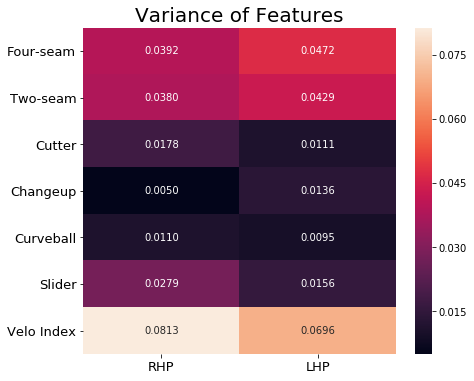

In [18]:
# Reset labels
labels = ["Four-seam", "Two-seam", "Cutter",
          "Changeup", "Curveball",
          "Slider", "Velo Index"]

normalized_rhp = normalized_rhp.drop(["percent_na", "percent_fs"], axis=1)
normalized_lhp = normalized_lhp.drop(["percent_na", "percent_fs"], axis=1)
variance = analyze_variance_threshold(normalized_rhp, normalized_lhp)
plot_variance_heatmap(variance)

## 4. Cluster Analysis

I will try out two different clustering techniques while trying to group pitchers into pitcher types. First, I will run kmeans, and afterwards I will run hierarchical clustering. In both clustering methods I will produce the RHP and LHP clusters separately. Later, I will evaluate the results from both clustering methods.

### 4.1 Kmeans - Finding k through the Elbow Method

Kmeans finds the sum of squared distances for a given amount of clusters (k). One popular method to decide how many clusters to use is through the elbow method, where we plot all sum of squared distances of k between 1 and 13, and then find the point at which the slope of the line starts to decrease less rapidly. This is an indication that the distances aren't decreasing that fast anymore, and we may have settled on a good number of clusters. 

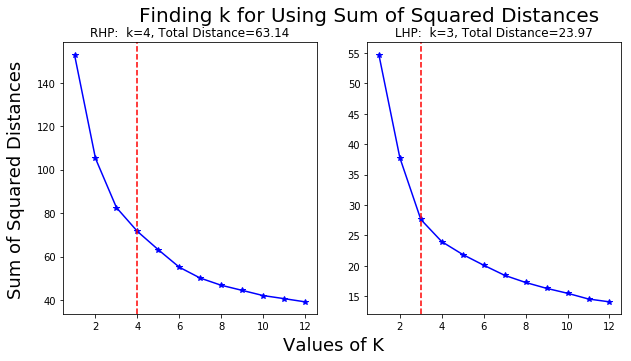

In [19]:
def plot_sum_of_squared_distances_and_get_optimal_k(df1, df2):
    fig, axes = plt.subplots(nrows=1, ncols=2,
                             sharex=False,
                             sharey=False,
                             figsize=(10, 5))
    
    p_throws_list = ["RHP", "LHP"]
    df_list = [df1, df2]
    for i, ax in enumerate(axes.flat):
        df = df_list[i]
        p_throws = p_throws_list[i]

        fields_to_drop = ["pitcher_id", "p_throws", "b_stands"]        
        sum_of_squared_distances = []
        k_range = range(1, 13)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, init='random', max_iter=1000) 
            kmeans = kmeans.fit(df.drop(fields_to_drop, axis=1))
            sum_of_squared_distances.append(kmeans.inertia_)
            
        ax.plot(k_range, sum_of_squared_distances, 'b*-')

        # Draw KneeLocator line
        y = sum_of_squared_distances
        x = range(1, len(y) + 1)
        kn = KneeLocator(x, y, curve='convex', direction='decreasing')
        ax.axvline(x=kn.knee, ymin=0.0, ymax=1.0, color='r', linestyle='--')
                
        # Set title
        distance = sum_of_squared_distances[kn.knee].round(2)
        ax.set_title("{}:  k={}, Total Distance={}"
                     .format(p_throws, kn.knee, distance))   
        
    fig.subplots_adjust(hspace=.3)
    fig.suptitle("Finding k for Using Sum of Squared Distances",
                     x=.55, fontsize=20)
    fig.text(0.5, 0.04, 'Values of K', ha='center',
             va='center', fontsize=18)
    fig.text(0.06, 0.5, 'Sum of Squared Distances', ha='center',
             va='center', rotation='vertical', fontsize=18)
    plt.show();

plot_sum_of_squared_distances_and_get_optimal_k(normalized_rhp, normalized_lhp)

While the KneeLocator dynamically picked up on the k=4 elbow for RHP, k=5 or k=6 look show a drop off as well. For LHP, k=3 or k=4 looks like a good amount of clusters. It makes sense that there would be fewer LHP clusters than RHP clusters, because there are far fewer pitchers in the LHP dataset.

### 4.1 Hierarchical Clustering - Plotting the Dendrograms

Next we will try to group pitchers using hierarchical clustering. This algorithm starts with 1 data point per cluster, and systematically combines data points that are most similar together until data points exceed a distance threshold.

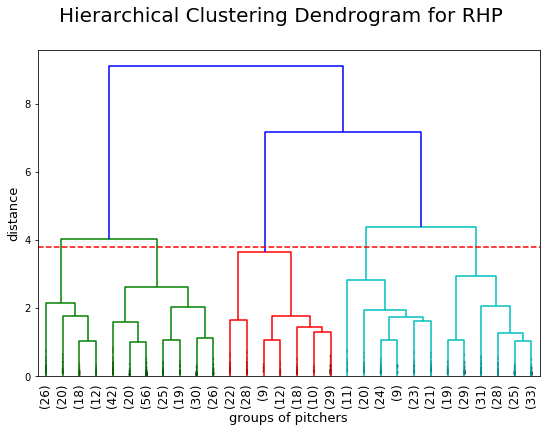

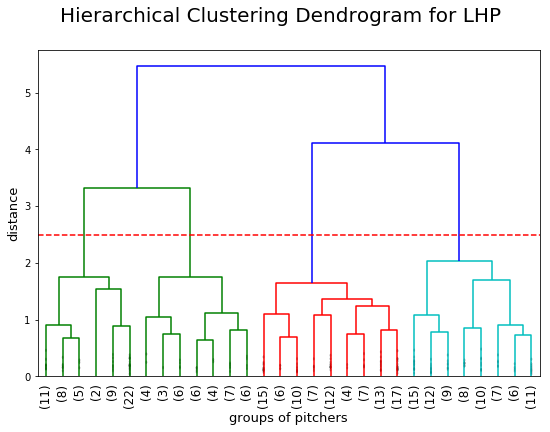

In [20]:
def plot_hierarchical_trees(df, dexterity, max_distance):
    fields_to_drop = ["pitcher_id", "p_throws", "b_stands"]        
    linkage_matrix = linkage(df.drop(fields_to_drop, axis=1), 'ward')

    fig = plt.figure(figsize=(9, 6))
    plt.axhline(max_distance, color='r', linestyle='--')

    dendrogram(
        linkage_matrix,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=30,  # show only the last p merged clusters
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,  # to get a distribution impression in truncated branches   
    )
    title = "Hierarchical Clustering Dendrogram for {}".format(dexterity)
    fig.suptitle(title, fontsize=20)
    plt.xlabel('groups of pitchers', fontsize=13)
    plt.ylabel('distance', fontsize=13)
    plt.show();   

    
rhp_distance = 3.8
lhp_distance = 2.5
plot_hierarchical_trees(normalized_rhp, "RHP", rhp_distance)
plot_hierarchical_trees(normalized_lhp, "LHP", lhp_distance)

The RHP clustering using this technique looks to be between 4-5 clusters, which is similar to what kmeans indicated. For LHP, the hierarchical clustering settled on 3-4 clusters, which also follows the kmeans clustering for LHP. In order to compare the two clustering techniques, I will use the same amount of clusters in each technique. 5 RHP clusters and 4 LHP clusters.

### 4.3 Analyzing Cluster Centers

Next, I will break down the average cluster centers for each clustering method.

In [21]:
def get_kmeans_clusters(df, c_list):
    df = df.copy(deep=True)
    k = len(c_list)
    fields_to_drop = ["pitcher_id", "p_throws", "b_stands"]
    df_numeric = df.copy(deep=True).drop(fields_to_drop, axis=1)
    kmeans = KMeans(n_clusters=k, init='random', max_iter=1000)
    kmeans = kmeans.fit(df_numeric) 
    df['cluster'] = kmeans.labels_ + c_list[0]
    return df
    
def get_hierarch_clusters(df, c_list, max_d):
    df = df.copy(deep=True)
    k = len(c_list)
    fields_to_drop = ["pitcher_id", "p_throws", "b_stands"]        
    linkage_matrix = linkage(df.drop(fields_to_drop, axis=1), 'ward')
    clusters = fcluster(linkage_matrix, max_d, criterion='distance')
    df['cluster'] = clusters + c_list[0]-1
    return df

# Generate list of clusters for convenience
clusters_rhp = [1,2,3,4,5]
clusters_lhp = [6,7,8,9]
clusters_list = list(itertools.chain(clusters_rhp, clusters_lhp))
clusters_list.sort()

clusters_df_list = []
# kmeans
clusters_df_list.append(get_kmeans_clusters(normalized_rhp, clusters_rhp))
clusters_df_list.append(get_kmeans_clusters(normalized_lhp, clusters_lhp))

# # hierarchical clustering
clusters_df_list.append(get_hierarch_clusters(normalized_rhp, clusters_rhp, rhp_distance))
clusters_df_list.append(get_hierarch_clusters(normalized_lhp, clusters_lhp, lhp_distance))

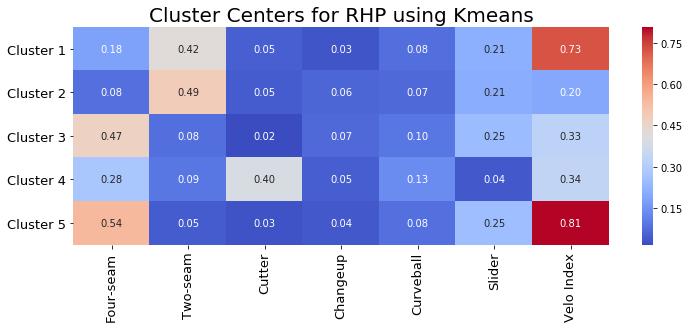

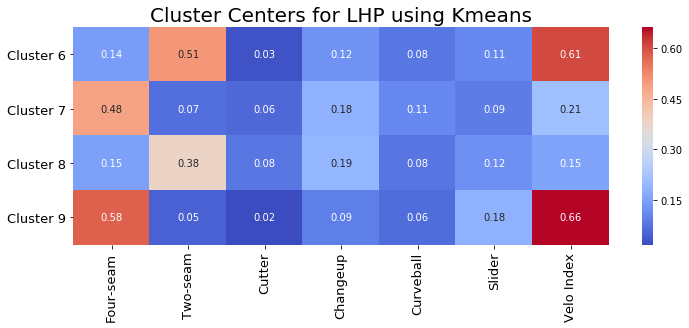

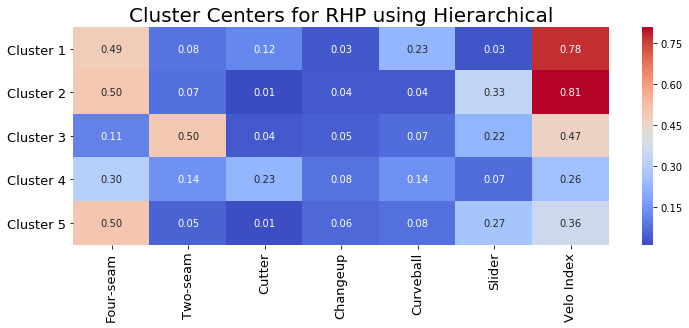

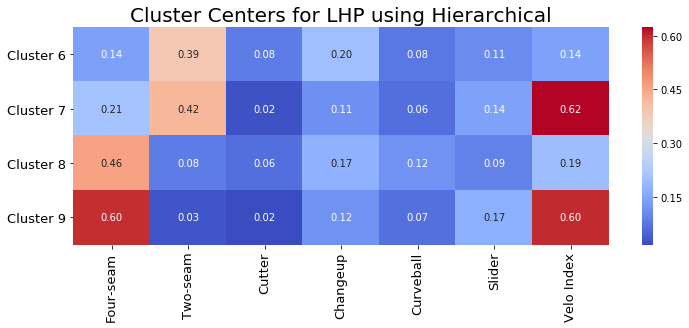

In [22]:
def plot_cluster_centers(df, c_list, dexterity, clust_type):
    k = len(c_list)

    # Take copy of df with with fields we want to cluster
    fields_to_drop = ["pitcher_id", "p_throws", "b_stands"]
    df_numeric = df.copy(deep=True).drop(fields_to_drop, axis=1)

    # Group pitchers by their cluster
    grouped = df_numeric.groupby(['cluster'], sort=True).mean()

    # generate heatmap
    plt.figure(figsize=(12, 4))
    fig = sns.heatmap(grouped, annot=True, fmt=".2f", cmap='coolwarm')

    # Set labels and title
    fig.set_xticklabels(labels, rotation=90, fontsize=13)
    ylabels = ["Cluster {}".format(i) for i in c_list]
    fig.set_yticklabels(ylabels, rotation=0, fontsize=13)
    fig.set_ylabel('')    
    plt.title("Cluster Centers for {} using {}".format(dexterity, clust_type), fontsize=20)

    # Display heatmap
    plt.show(); 

    
plot_cluster_centers(clusters_df_list[0], clusters_rhp, "RHP", "Kmeans")
plot_cluster_centers(clusters_df_list[1], clusters_lhp, "LHP", "Kmeans")
plot_cluster_centers(clusters_df_list[2], clusters_rhp, "RHP", "Hierarchical")
plot_cluster_centers(clusters_df_list[3], clusters_lhp, "LHP", "Hierarchical")

The clusters are largely driven by four-seam fastballs, two-seam fastballs, and velo index. This makes sense since these features had the most variance.

Lets look at a few pitchers to see how they are clustered, and to see if this falls in line with our intuition.

In [23]:
 def explore_examples(clusters_df_list):
    pitchers = {476454:"Dellin Betances", 547888:"Masahiro Tanaka",
               434378:"Justin Verlander", 502085:"David Robertson"}
    df_list = [clusters_df_list[0], clusters_df_list[2]]
    versions = ["kmeans", "hierarchical"]
    
    examples = pd.DataFrame()
    for key, value in pitchers.items():
        for i in range(0,len(df_list)):
            df = df_list[i]
            p = df.loc[(df["pitcher_id"] == key)]
            p["Pitcher"] = value
            p["Category"] = versions[i]
            examples = pd.concat([examples,p])    
    
    examples = examples[["Pitcher", "Category", "cluster"]]
    return examples.reset_index(drop=True)


explore_examples(clusters_df_list)

,Pitcher,Category,cluster
0,Dellin Betances,kmeans,5
1,Dellin Betances,hierarchical,1
2,Masahiro Tanaka,kmeans,3
3,Masahiro Tanaka,hierarchical,3
4,Justin Verlander,kmeans,5
5,Justin Verlander,hierarchical,2
6,David Robertson,kmeans,4
7,David Robertson,hierarchical,4


Betances and Verlander are power pitchers and their clusters reflect that. They're both in the clusters with the highest velo index. Interestingly, the hierarchical clustering indicated that Betances threw more curveballs and Verlanded threw more sliders, while the kmeans clustering didn't show this distinction. Robertson throws curveballs and cutters and sure enough his clusters pick up those pitch types.

### 4.4 Add Clusters to *atbat* Table

In order to use the pitcher clusters in the analysis I join the pitcher cluster into the atbat table.

In [24]:
def get_clustered_atbats_list(clusters_df_list):
    clustered_atbats_list = []
    for df in clusters_df_list:
        df.to_sql("temp_table", conn, if_exists="replace")
        sql = """select a.*, c.cluster
                 from atbats a
                 left join temp_table c
                 on a.pitcher_id = c.pitcher_id"""

        merged = pd.read_sql_query(sql, conn)

        # These pitchers aren't in the atbat table because they were filtered out ealier
        merged = merged[np.isfinite(merged['cluster'])]
        clustered_atbats_list.append(merged)
        
    return clustered_atbats_list


clustered_atbats_list = get_clustered_atbats_list(clusters_df_list)
clustered_atbats_list[0].tail()

# Close the db connection
conn.close()

,pitcher_id,batter_id,p_throws,b_stands,batter_name,pitcher_name,event,game_id,cluster
953826,450203.0,523253.0,R,R,Logan Forsythe,Charlie Morton,Flyout,gid_2017_11_01_houmlb_lanmlb_1,1.0
953827,450203.0,605131.0,R,R,Austin Barnes,Charlie Morton,Lineout,gid_2017_11_01_houmlb_lanmlb_1,1.0
953828,450203.0,400284.0,R,L,Chase Utley,Charlie Morton,Strikeout,gid_2017_11_01_houmlb_lanmlb_1,1.0
953829,450203.0,621035.0,R,R,Christopher Taylor,Charlie Morton,Groundout,gid_2017_11_01_houmlb_lanmlb_1,1.0
953830,450203.0,608369.0,R,L,Corey Seager,Charlie Morton,Groundout,gid_2017_11_01_houmlb_lanmlb_1,1.0


## 5. Model Analysis

Now that I have my clusters of pitcher types, I want to determine if I can better predict how batters will perform against each pitcher type. To test this, I will break up the *atbats* table into training and testing data. For the training data, I will calculate each batter's Weighted On Base Percentage (wOBP) against each type of pitcher, as well as each hitter's overall wOBP (against all pitchers). wOBP is similar to the standard OBP, or slugging percentage, but it tries to assign weights to each batting outcome in a more realistic way. For example, while slugging percentage would assign a weight of 1 for a single, 2 for a double, and 3 for a triple, wOBP might assign 1.4 for a double and 1.7 for a triple, since a double isn't twice as valuable as a single, and a triple is only marginally more valuable than a double. These wOBP stats are essentially my "predictions" for how the batters will perform in the testing data. To test these predictions I calculate the same set of wOBP in the testing data, and then asked the question, were my pitcher-type adjusted wOBP more accurate than the overall wOBP predictions?


### 5.1 Divide atbats into Training and Testing Data

I take a random 80% of the *atbats* as training data, and the remaining 20% as testing data.

In [25]:
def get_train_and_test_lists(clustered_atbats_list):
    train_list = []
    test_list = []
    for df in clustered_atbats_list:
        train, test = train_test_split(df, test_size=0.2)
        train_list.append(train)
        test_list.append(test)
        
    return train_list, test_list


train_list, test_list = get_train_and_test_lists(clustered_atbats_list)
train_list[0].head()

,pitcher_id,batter_id,p_throws,b_stands,batter_name,pitcher_name,event,game_id,cluster
20446,543243.0,518490.0,R,R,Bryce Brentz,Sonny Gray,Groundout,gid_2018_03_15_pitmlb_nyamlb_1,1.0
750657,593423.0,477165.0,R,L,Brett Wallace,Frankie Montas,Single,gid_2017_03_18_sdnmlb_oakmlb_1,1.0
790546,502624.0,611177.0,R,R,Adonis Garcia,Chase Anderson,Lineout,gid_2017_04_28_atlmlb_milmlb_1,3.0
946669,641871.0,553882.0,R,L,Omar Narvaez,None,Grounded Into DP,gid_2017_09_27_anamlb_chamlb_1,5.0
741387,571656.0,621037.0,R,R,Jason Leblebijian,Buck Farmer,Flyout,gid_2017_03_10_tormlb_detmlb_1,5.0


### 5.2 Calculate wOBP


In [35]:
def calculate_wobp_stats(df_list, calculate_overall_stats):
    
    valid_event = ["Single", "Double", "Triple", "Home Run", "Hit by Pitch",
                   "Intent Walk", "Walk" "Batter Out",
                   "Sac Fly Double Play", "Strikeout Double Play", 
                   "Bunt Lineout", "Triple Play", "Bunt Groundout", "Strikeout - DP", 
                   "Fielders Choice Out", "Sac Fly DP", "Fielders Choice",
                   "Sac Fly", "Lineout", "Double Play", "Grounded Into DP",
                   "Flyout", "Strikeout", "Forceout", "Groundout", "Pop Out"]
        
    pa_event =  ["Single", "Double", "Triple", "Home Run",
                   "Batter Out", "Strikeout Double Play", "Bunt Lineout",
                   "Triple Play", "Bunt Groundout", "Strikeout - DP", 
                   "Fielders Choice Out", "Fielders Choice", "Lineout", 
                   "Double Play", "Grounded Into DP", "Flyout", "Strikeout",
                   "Forceout", "Groundout", "Pop Out"]
    
    sac_fly_event = ["Sac Fly Double Play", "Sac Fly DP", "Sac Fly"]

    
    stats_list = []
    for i in range(0, len(df_list)):

        df = df_list[i].copy(deep=True)

        # Filter for valid events only
        df = df[df['event'].isin(valid_event)]

        # Determine the results for each batter
        df['pa'] = np.where(df['event'].isin(pa_event), 1, 0)

        df['wobp_num'] = np.where(df['event'] == "Walk", .69,
                            np.where(df['event'] == "Hit by Pitch", .72,
                            np.where(df['event'] == "Single", .88,
                            np.where(df['event'] == "Double", 1.247,
                            np.where(df['event'] == "Triple", 1.578,
                            np.where(df['event'] == "Home Run", 2.031, 0))))))

        df['wobp_denom'] = np.where(df['event'].isin(pa_event), 1,
                            np.where(df['event'] == "Walk", 1,
                            np.where(df['event'] == "Intent Walk", -1,
                            np.where(df['event'].isin(sac_fly_event), 1,
                            np.where(df['event'] == "Hit by Pitch", 1, 0)))))

        # Create dataframe to store stats
        stats_df = pd.DataFrame()

        # Get stats against each cluster
        for c in clusters_list:
            cluster_df = df.loc[df['cluster'] == c]
            col_pa = "cluster_{}_pa".format(c)
            col_wobp = "cluster_{}_wobp".format(c)

            stats_df[col_pa] = cluster_df.groupby(['batter_id'])['pa'].sum()
            numerator = cluster_df.groupby(['batter_id'])['wobp_num'].sum()
            denom = cluster_df.groupby(['batter_id'])['wobp_denom'].sum()
            stats_df[col_wobp] = numerator/denom 

        # This will be used for testing data, not training data
        if calculate_overall_stats:

            # Get overall stats
            stats_df["overall_pa"] = df.groupby(['batter_id'])['pa'].sum()
            num = df.groupby(['batter_id'])['wobp_num'].sum()
            denom = df.groupby(['batter_id'])['wobp_denom'].sum()
            stats_df["overall_wobp"] = num/denom

            # Get stats against RHP and LHP
            if i%2 == 0:
                against_rhp_df = df.loc[df['p_throws'] == 'R']
                stats_df["against_rhp_pa"] = against_rhp_df.groupby(['batter_id'])['pa'].sum()
                num = against_rhp_df.groupby(['batter_id'])['wobp_num'].sum()
                denom = against_rhp_df.groupby(['batter_id'])['wobp_denom'].sum()
                stats_df["against_rhp_wobp"] = num/denom
            else:
                against_lhp_df = df.loc[df['p_throws'] == 'L']
                stats_df["against_lhp_pa"] = against_lhp_df.groupby(['batter_id'])['pa'].sum()
                num = against_lhp_df.groupby(['batter_id'])['wobp_num'].sum()
                denom = against_lhp_df.groupby(['batter_id'])['wobp_denom'].sum()
                stats_df["against_lhp_wobp"] = num/denom

        # Set any NaN values to be 0
        stats_df = stats_df.fillna(0)
        
        # Append to the list 
        stats_list.append(stats_df)
    
    return stats_list


def get_overall_and_split_wobp(df_list, min_pa):
    # Drop batters that don't have at least 1 cluster with enough PA
    # Calculate overall wOBP and splits wOBP
    for df_num in range(0, len(df_list)):
        df = df_list[df_num]
        for i, row in df.iterrows():
            overall_pa = 0
            rhp_pa = 0
            lhp_pa = 0
            overall_summed_wobp = 0
            rhp_summed_wobp = 0
            lhp_summed_wobp = 0

            for c in clusters_list:
                col_pa = "cluster_{}_pa".format(c)
                col_wobp = "cluster_{}_wobp".format(c)
                cluster_pa = df.at[i, col_pa]
                cluster_weighted_wobp = cluster_pa * df.at[i, col_wobp]
                if cluster_pa > min_pa:
                    overall_pa += cluster_pa
                    overall_summed_wobp += cluster_weighted_wobp

                    if c in clusters_rhp:
                        rhp_pa += cluster_pa
                        rhp_summed_wobp += cluster_weighted_wobp
                    else:
                        lhp_pa += cluster_pa
                        lhp_summed_wobp += cluster_weighted_wobp

            if overall_pa > 0: 
                df.at[i,'overall_pa'] = overall_pa
                df.at[i,'overall_wobp'] = overall_summed_wobp/overall_pa
                if df_num%2 == 0:
                    df.at[i,'against_rhp_pa'] = rhp_pa
                    df.at[i,'against_rhp_wobp'] = rhp_summed_wobp/rhp_pa if (rhp_pa != 0) else 0
                else:
                    df.at[i,'against_lhp_pa'] = lhp_pa
                    df.at[i,'against_lhp_wobp'] = lhp_summed_wobp/lhp_pa if (lhp_pa != 0) else 0
            else:
                df.drop(i, inplace=True)   
            
    return df_list
    
    
min_pa = 100

# Generate train stats
train_stats_list = calculate_wobp_stats(train_list, False)
train_stats_list = get_overall_and_split_wobp(train_stats_list, min_pa)
train_stats_list[0].head()

# Generate test stats
test_stats_list = calculate_wobp_stats(test_list, True)
test_stats_list = get_overall_and_split_wobp(test_stats_list, min_pa)
test_stats_list[0].head()

,cluster_1_pa,cluster_1_wobp,cluster_2_pa,cluster_2_wobp,cluster_3_pa,cluster_3_wobp,cluster_4_pa,cluster_4_wobp,cluster_5_pa,cluster_5_wobp,...,cluster_7_pa,cluster_7_wobp,cluster_8_pa,cluster_8_wobp,cluster_9_pa,cluster_9_wobp,overall_pa,overall_wobp,against_rhp_pa,against_rhp_wobp
batter_id,,,,,,,,,,,,,,,,,,,,,
120074.0,107,0.337057,78.0,0.398117,200.0,0.324175,55.0,0.408255,207.0,0.493497,...,0.0,0.0,0.0,0.0,0.0,0.0,514.0,0.395047,514.0,0.395047
121347.0,69,0.154014,72.0,0.195622,153.0,0.301873,33.0,0.267545,131.0,0.292924,...,0.0,0.0,0.0,0.0,0.0,0.0,284.0,0.297745,284.0,0.297745
134181.0,189,0.335705,204.0,0.275083,340.0,0.314845,103.0,0.367257,352.0,0.321887,...,0.0,0.0,0.0,0.0,0.0,0.0,1188.0,0.317966,1188.0,0.317966
136860.0,149,0.364013,151.0,0.355349,291.0,0.263183,81.0,0.244827,246.0,0.295720,...,0.0,0.0,0.0,0.0,0.0,0.0,837.0,0.307322,837.0,0.307322
150029.0,111,0.240541,94.0,0.279821,245.0,0.245896,62.0,0.274460,242.0,0.237362,...,0.0,0.0,0.0,0.0,0.0,0.0,598.0,0.241448,598.0,0.241448


,cluster_1_pa,cluster_1_wobp,cluster_2_pa,cluster_2_wobp,cluster_3_pa,cluster_3_wobp,cluster_4_pa,cluster_4_wobp,cluster_5_pa,cluster_5_wobp,...,cluster_7_pa,cluster_7_wobp,cluster_8_pa,cluster_8_wobp,cluster_9_pa,cluster_9_wobp,overall_pa,overall_wobp,against_rhp_pa,against_rhp_wobp
batter_id,,,,,,,,,,,,,,,,,,,,,
400121.0,55,0.204804,28.0,0.309071,112.0,0.324063,24.0,0.146667,117.0,0.193308,...,0.0,0.0,0.0,0.0,0.0,0.0,229,0.257258,229,0.257258
405395.0,64,0.267438,81.0,0.477837,109.0,0.345275,33.0,0.378344,107.0,0.248587,...,0.0,0.0,0.0,0.0,0.0,0.0,216,0.297379,216,0.297379
408045.0,68,0.252851,40.0,0.264975,93.0,0.300613,31.0,0.182161,108.0,0.305868,...,0.0,0.0,0.0,0.0,0.0,0.0,108,0.305868,108,0.305868
408234.0,42,0.350732,29.0,0.399929,66.0,0.460844,34.0,0.444029,103.0,0.307069,...,0.0,0.0,0.0,0.0,0.0,0.0,103,0.307069,103,0.307069
425783.0,48,0.161958,35.0,0.459714,79.0,0.430570,29.0,0.234667,104.0,0.364202,...,0.0,0.0,0.0,0.0,0.0,0.0,104,0.364202,104,0.364202


### 5.3 Filter out Infrequent Batters

Filter out batters with fewer than 50 plate appearances.

In [36]:
def filter_out_batters(train_list, test_list):
    for i in range(0, len(train_list)):
        # Remove batters without a minimum number of PA
        train_list[i] = train_list[i].loc[train_list[i]['overall_pa'] > min_pa]
        test_list[i] = test_list[i].loc[test_list[i]['overall_pa'] > min_pa]

        # Remove batters that aren't in both the train data and test data
        train_list[i] = train_list[i].loc[train_list[i].index.isin(test_list[i].index)]
        test_list[i] = test_list[i].loc[test_list[i].index.isin(train_list[i].index)]

def get_num_batters_list(df_list):
    num_batters_list = []
    for df in df_list:
        num_batters_list.append(len(df))
    return num_batters_list


num_batters_list = get_num_batters_list(train_stats_list)    
filter_out_batters(train_stats_list, test_stats_list)

### 5.4 Use Training Stats as Predictions

Next, using the training wOBP as a prediction for what will happen in the test data, I assign predictions for each hitter.  

In [37]:
def compare_overall_versus_cluster_adjusted(train_list, test_list, min_pa):
    columns = ["Clustering Type", "Pitcher Dexterity", "Total # of Batters", 
               "# of Batters with Enough PA", "% of Batters with Enough PA",
               "Ave % of Clusters with Enough PA",
               "% Overall was Better", "% Cluster-Adj was Better",
               "Ave % Improvement for Cluster-Adj"]
    results = pd.DataFrame(columns=columns)
    cluster_type_list = ["Kmeans", "Kmeans", "Hierarchical", "Hierarchical"]
    pitcher_dexterity_list = ["RHP", "LHP", "RHP", "LHP"]
    for df_num in range(0, len(train_list)):
        train = train_list[df_num]
        test = test_list[df_num]
        diff_overall = 0.0
        diff_cluster_adj = 0.0
        count_overall_better = 0.0
        count_adjusted_better = 0.0
        stat_count = 0
        for i, row in test.iterrows():
            train_overall_wobp = train.at[i,'overall_wobp']
            for c in clusters_list:
                col_pa = "cluster_{}_pa".format(c)
                col_wobp = "cluster_{}_wobp".format(c)
                train_cluster_pa = train.at[i,col_pa]
                test_cluster_pa = test.at[i,col_pa]

                if train_cluster_pa > min_pa and test_cluster_pa > min_pa*.25:
                    stat_count += 1
                    cluster_adjusted_predict = test_cluster_pa*train.at[i,col_wobp]
                    overall_predict = test_cluster_pa*train_overall_wobp

                    actual_wobp = test.at[i,col_wobp]

                    new_diff_overall = abs(overall_predict-actual_wobp)
                    new_diff_cluster_adj = abs(cluster_adjusted_predict-actual_wobp)

                    diff_overall += new_diff_overall
                    diff_cluster_adj += new_diff_cluster_adj

                    if new_diff_cluster_adj < new_diff_overall:
                        count_adjusted_better += 1
                    else:
                        count_overall_better += 1

        if stat_count > 0:
            ave_diff_overall = diff_overall/stat_count
            ave_diff_cluster_adj = diff_cluster_adj/stat_count
            num_batters_total = num_batters_list[df_num]
            num_batters_used = len(train)
            percent_batters_with_enough_pa = round(100*num_batters_used/num_batters_total, 2)
            num_clusters_used = count_adjusted_better+count_overall_better
            percent_clusters_with_enough_pa = round((100*num_clusters_used)
                                                   /(num_batters_used*len(clusters_list)), 2)
            percent_overall_better = round(100*count_overall_better/num_clusters_used, 2)
            percent_cluster_adj_better = 100-percent_overall_better
            improved = (ave_diff_overall-ave_diff_cluster_adj)/ave_diff_overall

            new_result = pd.Series([cluster_type_list[df_num],
                                    pitcher_dexterity_list[df_num],
                                    num_batters_total,
                                    num_batters_used,
                                    percent_batters_with_enough_pa,
                                    percent_clusters_with_enough_pa,
                                    percent_overall_better,
                                    percent_cluster_adj_better,
                                    improved], index=columns)

            results = results.append(new_result, ignore_index=True)

    return results


compare_overall_versus_cluster_adjusted(train_stats_list, test_stats_list, min_pa)


,Clustering Type,Pitcher Dexterity,Total # of Batters,# of Batters with Enough PA,% of Batters with Enough PA,Ave % of Clusters with Enough PA,% Overall was Better,% Cluster-Adj was Better,Ave % Improvement for Cluster-Adj
0,Kmeans,RHP,472,93,19.7,49.34,50.36,49.64,-0.000317
1,Hierarchical,RHP,446,58,13.0,52.87,49.64,50.36,0.000641


The results from the analysis are inconclusive. There are many reasons why this might be the case, but I perhaps the biggest issue is the lack of sample size. In the table above we see that less than 20% of RHB have enough plate appearances in at least one cluster to be included in the dataset. And within those list of limited batters who *are* included, only around half of their individual cluster averages have enough plate appearances to be included in the calculations. Even worse, not a single LHB has enough sample size to be included in the analysis. That leaves us with very few instances where batters have faced a pitcher type enough times to draw any meaningful conclusions. This issue isn't easily solvable by adding more years of data to the calculations, because even if we added data from previous years (say, data from 2005-2015), hitters and pitchers often change drastically over the course of a few years. A pitcher from 2010 might have thrown completely different pitches than he throws today. This makes it difficult to collect enough data points to be used in the analysis. 

Nonetheless, there are many ways to expand on this analysis to try to find conclusive results. One idea is to create my own classifications of pitcher types and use supervised learning rather than unsupervised learning. Additionally, there are numerous other features of pitchers that could be used in the clustering, such as spin rates, release points, and the outcome of certain pitches.